# 5) 감성분석(BERT)

In [23]:
#       pretrained model        transfer learning
#       사전학습된 모델          전이학습


#       fine tuning(파인 튜닝)

#       A model
#               input
#               hidden-1
#               ...
#               hiddend-n
#               ouput
#       Model
#               A
#               hidden
#               hidden
#               output

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델 및 토크나이저 불러오기

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
#    토크나이저 - 형태소 분석 => 정수 인코딩
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
#                분류모델                                              대소문자 구별     분류 클래스 수

# 사전훈련된 모델
#       up-stream 작업 : 
# 파인 튜닝 모델
#       down-stream 작업 : 사전학습 모델을 불러온 후 추가로 처리하고자 하는 작업

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import torch

# 긍정/부정 데이터셋 준비
dic = {0:'positive', 1:'neutral', 2:'negative'}
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]

ans = torch.tensor([0, 0, 1, 2, 2, 0])

In [26]:
# 파인 튜닝을 하지 않고 테스트

model.eval()  # 추론모드 x

with torch.no_grad(): # 가중치 업데이트 x
  for article in eval_list:
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)
    print(inputs)
    outputs = model(inputs)
    print(outputs)
    logits = outputs.logits
    print(f"{dic[logits.argmax(-1).item()]} : {article}")
#결과가 중립으로 나타남, 학습이 필요한 상태임

tensor([[  101,   146,  1176, 12075,   102]])
SequenceClassifierOutput(loss=None, logits=tensor([[0.3028, 0.3942, 0.1031]]), hidden_states=None, attentions=None)
neutral : I like apple
tensor([[  101,   146,  1176,   185, 19386,   102]])
SequenceClassifierOutput(loss=None, logits=tensor([[0.3138, 0.3419, 0.1476]]), hidden_states=None, attentions=None)
neutral : I like pear
tensor([[ 101,  146, 1301, 1106, 1278,  102]])
SequenceClassifierOutput(loss=None, logits=tensor([[0.2042, 0.3836, 0.1133]]), hidden_states=None, attentions=None)
neutral : I go to school
tensor([[  101,   146, 20662,   182,  2155, 21594,   102]])
SequenceClassifierOutput(loss=None, logits=tensor([[0.2959, 0.3428, 0.1383]]), hidden_states=None, attentions=None)
neutral : I dislike mosquito
tensor([[ 101,  146, 1464, 1304, 6782,  102]])
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.2840,  0.4008, -0.0005]]), hidden_states=None, attentions=None)
neutral : I felt very sad
tensor([[ 101,  146, 1631, 1177, 1363, 

In [27]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)
#                                       학습률
model.train()   # 학습모드로 전환
epochs = 50
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()   # 가중치 초기화
    inputs = tokenizer.batch_encode_plus(eval_list, return_tensors="pt", padding=True, truncation=True)
#                                                                                         미니배치로 여러개 한꺼번에 처리
    outputs = model(**inputs, labels=ans)
#                    ** 딕셔너리
    logits = outputs.logits
    loss = outputs.loss     # 손실
    # 오차역전파
    loss.backward()     # 계산
    # 가중치(weight) 업데이트
    optimizer.step()
    losses.append(loss)

    print(f"epoch:{epoch+1}, loss:{loss}")

epoch:1, loss:1.1955610513687134
epoch:2, loss:1.0080581903457642
epoch:3, loss:1.0518878698349
epoch:4, loss:1.0362719297409058
epoch:5, loss:0.9171051383018494
epoch:6, loss:0.8837254643440247
epoch:7, loss:0.9195280075073242
epoch:8, loss:0.834391176700592
epoch:9, loss:0.8376151919364929
epoch:10, loss:0.7859699726104736
epoch:11, loss:0.7980906963348389
epoch:12, loss:0.7182087302207947
epoch:13, loss:0.637240469455719
epoch:14, loss:0.7296583652496338
epoch:15, loss:0.6730716824531555
epoch:16, loss:0.6495402455329895
epoch:17, loss:0.6037158370018005
epoch:18, loss:0.5633955001831055
epoch:19, loss:0.5893463492393494
epoch:20, loss:0.5602310299873352
epoch:21, loss:0.4829390347003937
epoch:22, loss:0.5005581974983215
epoch:23, loss:0.5610405206680298
epoch:24, loss:0.48284903168678284
epoch:25, loss:0.5281530618667603
epoch:26, loss:0.49215421080589294
epoch:27, loss:0.4492703378200531
epoch:28, loss:0.44396793842315674
epoch:29, loss:0.45562246441841125
epoch:30, loss:0.3934830

In [28]:
new_losses = [i.item() for i in losses]

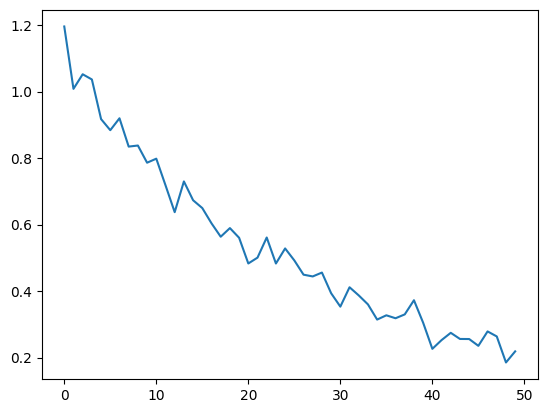

In [29]:
import matplotlib.pyplot as plt

plt.plot(new_losses)

In [30]:
# 파인 튜닝 이후 추론

dic = {0:'positive', 1:'neutral', 2:'negative'}
eval_list = ["I like apple", "I like pear", "I go to school", "I dislike mosquito", "I felt very sad", "I feel so good"]
model.eval()
preds = []

with torch.no_grad():
  for article in eval_list:
    inputs = tokenizer.encode(article, return_tensors="pt",padding=True, truncation=True)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    preds.append(logits.argmax(-1).item())

    print(f"{dic[pred]}:{article}")
# 파인튜닝 이후 성능이 개선됨

positive:I like apple
positive:I like pear
neutral:I go to school
negative:I dislike mosquito
negative:I felt very sad
positive:I feel so good


In [31]:
import torch

preds = torch.tensor(preds)
preds

tensor([0, 0, 1, 2, 2, 0])

In [32]:
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

Accuracy:100.0%
